(perc-lab)=
# Perceptron

In [1]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl        # plotting

In [2]:
import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


## Uczenie nadzorowane

W poprzednich rozdziałach pokazaliśmy, że nawet najprostsze sieci ANN mogą wykonywać przydatne zadania (emulować sieci logiczne lub dostarczać proste modele pamięci). Ogólnie rzecz biorąc, każdy ANN ma

- pewną **architekturę**, czyli liczbę warstw, liczbę neuronów w każdej warstwie, schemat połączeń między neuronami (w pełni połączone lub nie, feed-forward, rekurencyjne, ...);

- **wagi (hiperparametry)** na połącznieach, z określonymi wartościami definiującymi funkcjonalność sieci.

Podstawowym pytaniem praktycznym jest to, jak ustawić (dla danej architektury) wagi tak, aby żądany cel funkcjonalności sieci został zrealizowany, tj. dla określonych danych wejściowych uzuskać pożądany wynik na wyjściu.
W zadaniach omówionych wcześniej wagi mogą być skonstruowane *a priori*, czy to dla bramek logicznych, czy dla modeli pamięci. Jednak dla bardziej skomplikowanych aplikacji chcemy mieć „łatwiejszy” sposób określania wag. Co więcej, dla skomplikowanych problemów „teoretyczne” określenie wag a priori nie jest w ogóle możliwe. To podstawowy powód, dla którego wymyślono **algorytmy uczenia się** sieci, które ,,automatycznie" dostosowują wagi na podstawie dostępnych danych.

W tym rozdziale rozpoczynamy badanie takich algorytmów, poczynając od podejścia **uczenia nadzorowanego**, stosowanego m.in. do klasyfikacji danych.

```{admonition} Uczenie nadzorowane
:class: important

W tej strategii dane muszą posiadać **etykiety**, które a priori określają poprawną kategorię dla każdego punktu. Pomyślmy na przykład o zdjęciach zwierząt (dane lub cechy, ang. features) i ich opisach (kot, pies,...), które nazywane są etykietami (ang. labels).
Te etykietowane dane są następnie dzielone na próbkę **szkoleniową** i próbkę **testową**.

Podstawowe kroki uczenia nadzorowanego dla danej ANN są następujące:

- Zainicjuj w jakiś sposób wagi, na przykład losowo lub na zero.

- Odczytuj kolejno punkty danych z próbki szkoleniowej i przepuszczaj je przez swoją sieć ANN. Otrzymana odpowiedź może różnić się od prawidłowej, zawartej w etykiecie. W takim przypadku wagi są zmieniane zgodnie z konkretną receptą (o czym później).

- W razie potrzeby powtórz poprzedni krok. Zazwyczaj wagi zmienia się coraz mniej w miarę postępu algorytmu.

- Zakończ szkolenie sieci po osiągnięciu kryterium zatrzymania (wagi nie zmieniają się już znacznie lub została osiągnięta maksymalna liczba iteracji).

- Przetestuj tak wyszkoloną ANN na próbce testowej.

Jeśli jesteśmy zadowoleni, mamy pożądaną wyszkoloną sieć ANN wykonującą określone zadanie (takie jak np. klasyfikacja danych), której można teraz używać na nowych, nieetykietowanych danych. Jeśli nie, możemy inaczej podzielić próbkę na część szkoleniową i testową, po czym powtórzyć procedurę uczenia od początku. Możemy także spróbować pozyskać więcej danych (co może być kosztowne), lub też zmienić architekturę sieci.

Termin „nadzorowany” pochodzi z interpretacji procedury, w której etykiety posiadane są przez „nauczyciela”, który w ten sposób wie, które odpowiedzi są prawidłowe, a które błędne i który **nadzoruje** w ten sposób proces szkolenia. Oczywiście program komputerowy ma wbudowanego nauczyciela. tj. "nadzoruje się" sam.
```

## Perceptron jako klasyfikator binarny

Najprostszy algorytm uczenia nadzorowanego
to [perceptron](https://en.wikipedia.org/wiki/Perceptron), wymyślony w 1958 roku przez Franka Rosenblatta. Może służyć m.in. do
konstruowania **klasyfikatorów binarnych** danych. *Binarny* oznacza, że sieć
służy do oceny, czy element danych ma określoną cechę, czy nie - są tylko dwie możliwości. Klasyfikacja wieloetykietowa jest również możliwa w przypadku ANN (patrz ćwiczenia), ale nie omawiamy jej tutaj.

```{Admonition} Uwaga
:class: note
Termin *perceptron* jest również używany dla ANN (bez lub z warstwami pośrednimi) składających się z neuronów MCP (por. rys. {numref}`ffnn-fig` i {numref}`MCP1-fig`), na których wykonywany jest algorytm perceptronu.
```

### Próbka ze znaną regułą klasyfikacji

Na początek potrzebujemy danych treningowych, które wygenerujemy jako losowe punkty w kwadracie. Zatem współrzędne punktu, $x_1$ i $x_2$, należą do przedziału $[0,1]$. Definiujemy dwie kategorie: jedną dla punktów leżących powyżej linii $x_1=x_2$ (nazwijmy je różowymi) oraz drugą dla punktów leżących poniżej tej linii (niebieskie). Podczas losowego generowania danych sprawdzamy, czy $x_2 > x_1$ czy nie i przypisujemy odpowiednią  **etykietę** do każdego punktu, równą odpowiednio 1 lub 0. Te etykiety są oczekiwanymi „prawdziwymi” odpowiedziami sieci po jej wyszkoleniu.

Funkcja generująca opisany powyżej punkt danych z etykietą to

In [3]:
def point():     # generates random coordinates x1, x2, and 1 if x2>x1, 0 otherwise
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1):                     # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

Generujemy **próbkę szkoleniową**, składającą się z **npo**=300 etykietowanych punktów danych:

In [4]:
npo=300 # number of data points in the training sample

print('  x1         x2         label')       # header
samp=np.array([point() for _ in range(npo)]) # training sample, _ is dummy iterator
print(samp[:5, :])                           # first 5 data points

  x1         x2         label
[[0.32934056 0.39891895 1.        ]
 [0.87245402 0.23216823 0.        ]
 [0.34298363 0.15572279 0.        ]
 [0.85658971 0.99224611 1.        ]
 [0.78826375 0.03085404 0.        ]]


```{admonition} Pętle w tablicy
:class: warning

W Pythonie można wygodnie zdefiniować tablicę poprzez pętlę, np.
[i**2 for i in range(4)] daje [1,4,9].


W pętlach, jeśli wskaźnik nie występuje jawnie w wyrażeniu, można użyć symbolu **_** , np. 

[point() for _ in range(npo)]
```

```{admonition} Zakresy w tablicach
:class: warning

Aby nie drukować niepotrzebnie bardzo długiej tabeli, po raz pierwszy użyliśmy powyżej **zakresów dla wskaźników tablic**. Np. 2:5 oznacza od 2 do 4 (przypomnijmy, że ostatni jest wykluczony!), :5 - od 0 do 4, 5: - od 5 do końca, wreszcie : - wszystkie elementy.
```

Nasze wygenerowane dane przedstawia graficznie poniższy rysunek. Wykreślamy również linię $x_2=x_1$, która oddziela niebieskie i różowe punkty. W tym przypadku podział jest możliwy a priori (znamy regułę) w sposób dokładny.

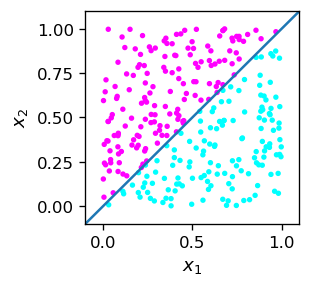

In [5]:
plt.figure(figsize=(2.3,2.3),dpi=120)                 
plt.xlim(-.1,1.1)                                  # axes limits
plt.ylim(-.1,1.1)
plt.scatter(samp[:,0],samp[:,1],c=samp[:,2],       # label determines the color
            s=5,cmap=mpl.cm.cool)                  # point size and color

plt.plot([-0.1, 1.1], [-0.1, 1.1])                 # separating line

plt.xlabel('$x_1$',fontsize=11)                    
plt.ylabel('$x_2$',fontsize=11)

plt.show()

```{admonition} Zbiory liniowo rozłączne
:class: important

Dwa zbiory punktów (tutaj niebieski i różowy) na płaszczyźnie, które można rozdzielić linią prostą, nazywamy **liniowo rozłącznymi** (separowalnymi). W trzech wymiarach zbiory muszą być separowalne płaszczyzną, ogólnie w $n$ wymiarach  zbiory muszą być separowalne za pomocą  $n-1$ wymiarowej hiperpłaszczyzny.
```

Analitycznie, jeżeli punkty w przestrzeni $n$ wymiarowej  mają współrzędne $(x_1,x_2,\dots,x_n)$, to można dobrać parametry $(w_0,w_1,\dots,w_n)$ w taki sposób, aby zbiór jeden punktów spełniał warunek

```{math}
:label: eq-linsep

w_0+x_1 w_1+x_2 w_2 + \dots x_n w_n > 0
```

a drugi warunek przeciwny, ze znakiem $>$ zastąpionym przez $\le$.

A teraz kluczowa, choć oczywista obserwacja: powyższa nierówność jest dokładnie warunkiem zaimplementowanym w [neuronie MCP](laboratorium MCP) (ze schodkową funkcją aktywacji) w konwencji {numref}`MCP2-fig`! Możemy więc zrealizować warunek {eq}`eq-linsep` za pomocą funkcji **neuron** z biblioteki **neural**.

W naszym przykładzie dla różowych punktów, według konstrukcji,

$$
x_2>x_1 \to s=-x_1+x_2 >0
$$

skąd, używając równ. {eq}`eq-linsep`, możemy od razu odczytać

$$
w_0=0, \;\; w_1=-1, w_2=1.
$$

Zatem funkcja **neuron** dla punktu próbki p jest używana w następujący sposób:

In [6]:
p=[0.6,0.8]      # sample point with x_2 > x_1
w=[0,-1,1]       # weights as given above

func.neuron(p,w) 

1

Neuron, odpalił, więc punkt p jest różowy.

```{admonition} Wniosek
:class: important

Pojedynczy neuron MCP z odpowiednio dobranymi wagami może być użyty jako klasyfikator binarny dla $n$-wymiarowych danych separowalnych.
```

### Próbka o nieznanej regule klasyfikacji

W tym miejscu czytelnik może być nieco zwiedziony pozorną błahością wyników. Wątpliwości mogą wynikać z tego, że w powyższym przykładzie od początku znaliśmy regułę określającą dwie klasy punktów ($x_2>x_1$, lub odwrotnie). Jednak w ogólnej sytuacji „z prawdziwego życia” zwykle tak nie jest! Wyobraź sobie, że napotykamy (etykietowane) dane **samp2** wyglądające tak:

In [7]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):           # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

In [8]:
samp2=np.array([point2() for _ in range(npo)])              

In [9]:
print(samp2[:5])

[[0.50896192 0.26237741 0.        ]
 [0.50775256 0.1093865  0.        ]
 [0.44707124 0.04838339 0.        ]
 [0.26519082 0.33358304 0.        ]
 [0.5661581  0.53616119 0.        ]]


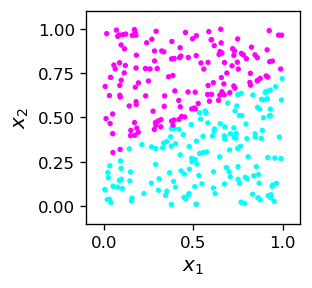

In [10]:
plt.figure(figsize=(2.3,2.3),dpi=120)                 
plt.xlim(-.1,1.1)                                  
plt.ylim(-.1,1.1)
plt.scatter(samp2[:,0],samp2[:,1],c=samp2[:,2],     
            s=5,cmap=mpl.cm.cool)                  

plt.xlabel('$x_1$',fontsize=12)                    
plt.ylabel('$x_2$',fontsize=12)

plt.show()

Sytuacja jest teraz w pewnym sensie odwrócona. Uzyskaliśmy skądś (liniowo separowalne) dane i chcemy znaleźć regułę, która definiuje te dwie klasy. Innymi słowy, musimy narysować linię podziału, która jest równoważna ze znalezieniem wag neuronu MCP {numref}`MCP2-fig`, który przeprowadziłby odpowiednią klasyfikację binarną.

(lab-pa)=
## Algorytm perceptronu

Moglibyśmy spróbować jakoś obliczyć właściwe wagi dla powyższego przykładu i znaleźć linię podziału, na przykład linijką i ołówkiem, ale nie o to tutaj chodzi. Chcemy mieć systematyczną procedurę algorytmiczną, która bez trudu zadziała w tej czy każdej podobnej sytuacji. Odpowiedzią jest wspomniany już [algorytm perceptronu](https://en.wikipedia.org/wiki/Perceptron).

Przed przedstawieniem algorytmu zauważmy, że neuron MCP z pewnym zbiorem wag $w_0, w_1, w_2$ zawsze daje jakąś odpowiedź dla etylirtowanego punktu danych, poprawną lub błędną. Na przykład

In [11]:
w=[-0.5,1,0]           # arbitrary choice of weights

print("label  answer") # header

for i in range(5): # look at first 5 points
    print(int(samp2[i,2]),"    ",func.neuron(samp2[i,:2],w)) 
            # samp2[i,2] is the label, samp2[i,:2] is [x_1,x_2]

label  answer
0      1
0      1
0      0
0      0
0      1


Widzimy, że niektóre odpowiedzi są równe etykietom (poprawne), a inne są od nich różne (błędne). Ogólną ideą jest teraz **użycie błędnych odpowiedzi**, aby sprytnie, małymi krokami zmieniać wagi, tak aby po wystarczającej liczbie iteracji wszystkie odpowiedzi dla danej próbki szkoleniowej były poprawne!

```{admonition} Algorytm perceptronu
:class: important

Iterujemy po punktach próbki danych szkoleniowych.
Jeżeli dla danego punktu otrzymany wynik $y_o$ jest równy prawdziwej wartości $y_t$ (etykieta), tj. odpowiedź jest prawidłowa, nic nie robimy. Jeśli jednak jest błędna, zmieniamy nieco wagi, tak aby szansa na otrzymanie błędnej odpowiedzi spadła. Przepis jest następujący:

$w_i \to w_i  +  \varepsilon  (y_t - y_o)  x_i$,

gdzie $ \varepsilon $ to mała liczba (nazywana **szybkością uczenia**), a $x_i$ to współrzędne punktu wejściowego, gdzie $i=0,\dots,n$. 
```

Prześledźmy, jak to działa. Załóżmy najpierw, że $x_i> 0$. Wtedy jeśli etykieta $ y_t = 1 $ jest większa niż uzyskana odpowiedź $ y_o = 0 $, waga $w_i$ jest zwiększana. Wtedy $w \cdot x$ również wzrasta, a $ y_o = f (w \cdot x) $ z większą szansą przyjmie poprawną wartość 1 (pamiętamy, jak wygląda funkcja schodkowa $f$). Jeżeli natomiast etykieta $y_t = 0 $ jest mniejsza niż uzyskana odpowiedź $ y_o = 1 $, to waga $w_i$ maleje, $ w \cdot x $ maleje, a $ y_o = f(w \cdot x) $ ma większą szansę na osiągnięcie prawidłowej wartości 0.

Jeśli $ x_i < 0 $, łatwo analogicznie sprawdzić, że przepis również działa poprawnie.

Jeśli odpowiedź jest prawidłowa, $y_t=y_0$, to $ w_i \to w_i$, więc nic się nie zmienia. Nie „psujemy” perceptronu!

Powyższy wzór można zastosować wielokrotnie dla tego samego punktu z próbki szkoleniowej. Następnie wykonujemy pętlę po wszystkich punktach próbki, a całą procedurę można jeszcze powtarzać w wielu rundach, aby uzyskać stabilne wagi (nie zmieniające się już w miarę kontynuacji procedury lub zmieniające się tylko nieznacznie).

Zazwyczaj w takich algorytmach szybkość uczenia $ \varepsilon $ jest zmniejszana w kolejnych rundach. Jest to bardzo ważne z praktycznego punktu widzenia, ponieważ zbyt duże aktualizacje mogą zepsuć uzyskane rozwiązanie.

Implementacja algorytmu perceptronu dla danych dwuwymiarowych w Pythonie wygląda następująco:

In [12]:
w0=np.random.random()-0.5  # initialize weights randomly in the range [-0.5,0.5]
w1=np.random.random()-0.5
w2=np.random.random()-0.5

eps=.3                     # initial  learning speed 
   
for _ in range(20):        # loop over rounds
    eps=0.9*eps            # in each round decrease the learning speed 
        
    for i in range(npo):   # loop over the points from the data sample
        
        for _ in range(5): # repeat 5 times for each points
            
            yo = func.neuron(samp2[i,:2],[w0,w1,w2]) # obtained answer
            
            w0=w0+eps*(samp2[i,2]-yo)   # weight update (the perceptron formula)
            w1=w1+eps*(samp2[i,2]-yo)*samp2[i,0]
            w2=w2+eps*(samp2[i,2]-yo)*samp2[i,1]

print("Obtained weights:")
print("  w0     w1     w2")        # header 
w_o=np.array([w0,w1,w2])           # obtained weights
print(np.round(w_o,3))             # result, rounded to 3 decimal places 


Obtained weights:
  w0     w1     w2
[-0.562 -1.114  2.192]


In [13]:
# for the separating line
def l2(w0,w1,w2):
    return [-.1,1.1],[-(w0-w1*0.1)/w2,-(w0+w1*1.1)/w2]

# corresponding separating line
lin=l2(w0,w1,w2)

Otrzymane wagi, jak wiemy, definiują linię podziału. Tak więc, geometrycznie, algorytm tworzy linię podziału, narysowaną poniżej wraz z próbką szkoleniową.

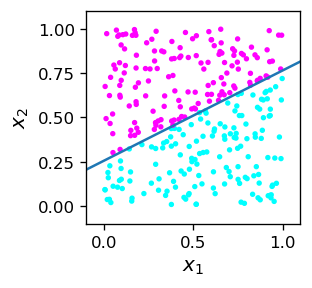

In [14]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(samp2[:,0],samp2[:,1],c=samp2[:,2],s=5,cmap=mpl.cm.cool)

plt.plot(lin[0],lin[1]) # plot the obtained separating line

plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12) 

plt.show()

Widzimy, że algorytm działa! Wszystkie różowe punkty znajdują się powyżej linii podziału, a wszystkie niebieskie poniżej. Podkreślmy, że linia podziału dana przez równanie

$$ w_0+x_1 w_1 + x_2 w_2=0,$$

nie wynika z naszej wiedzy a priori, ale z treningu (uczenia nadzowowanego) neuronu MCP, który odpowiednio dopasowuje swoje wagi.


``` {uwaga}
Można udowodnić, że algorytm perceptronu jest zbieżny wtedy i tylko wtedy, gdy dane są liniowo separowalne.
```

Teraz możemy wyjawić nasz sekret! Dane próbki szkoleniowej **samp2** zostały etykietowane w momencie tworzenia regułą

$$ x_2> 0,25+0,52 x_1, $$

co odpowiada wagom $w_0=0.25$, $w_1=-0.52$, $w_2=1$.

In [15]:
w_c=np.array([-0.25,-0.52,1]) # weights used for labeling the training sample
print(w_c)

[-0.25 -0.52  1.  ]


Zwróćmy uwagę, że nie są to wcale te same wagi, jakie uzyskano podczas treningu:

In [16]:
print(np.round(w_o,3))

[-0.562 -1.114  2.192]


Powód jest dwojaki. Po pierwsze, zauważmy, że warunek nierówności {eq}`eq-linsep` pozostaje niezmieniony, jeśli pomnożymy obie stronynierówności  przez **dodatnią** stałą $c$. Możemy zatem przeskalować wszystkie wagi przez $c$, a sytuacja (odpowiedzi neuronu MCP, linia podziału) pozostaje dokładnie taka sama (napotykamy tutaj **klasę równoważności** wag przeskalowanych o czynnik dodatni) .

Z tego powodu dzieląc uzyskane wagi przez wagi użyte do oznaczenia próbki, otrzymujemy (prawie) stałe wartości:

In [17]:
print(np.round(w_o/w_c,3))

[2.249 2.143 2.192]


Powodem, dla którego wartości stosunków wag dla $i=0,1,2$ nie są dokładnie takie same, jest to, że próbka ma skończoną liczbę punktów (tutaj 300). W ten sposób zawsze istnieje pewna luka między dwiema klasami punktów i jest trochę miejsca na nieznaczne przesuwanie linii rozdzielającej. Przy większej liczbie punktów danych efekt różnicy stosunków wag zmniejsza się (patrz ćwiczenia).

### Testowanie klasyfikatora

Ze względu na ograniczoną wielkość próbki szkoleniowej i opisany powyżej efekt „luki”, wynik klasyfikacji na próbce testowej jest czasami błędny. Dotyczy to zawsze punktów w pobliżu linii podziału, która jest wyznaczana z dokładnością zależną od krotności próbki szkoleniowej. Poniższy kod przeprowadza sprawdzenie na próbce testowej. Próbka ta składa się z etykietowanych danych wygenerowanych losowo za pomocą tej samej funkcji **point2** użytej uprzednio do wygenerowania danych szkoleniowych:

In [18]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):           # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

Kod testujący jest następujący:

In [19]:
er= np.empty((0,3))  # initialize an empty 1 x 3 array to store misclassified points

ner=0                 # initial number of misclassified points
nt=10000               # number of test points

for _ in range(nt):   # loop over the test points
    ps=point2()       # a test point 
    if(func.neuron(ps[:2],[w0,w1,w2])!=ps[2]): # if wrong answer                                      
        er=np.append(er,[ps],axis=0)           # add the point to er
        ner+=1                                 # count the number of errors
        
print("number of misclassified points = ",ner," per ",nt," (", np.round(ner/nt*100,1),"% )")        

number of misclassified points =  20  per  10000  ( 0.2 % )


Jak widać, niewielka liczba punktów testowych jest błędnie sklasyfikowana. Wszystkie te punkty leżą w pobliżu linii rozdzielającej.

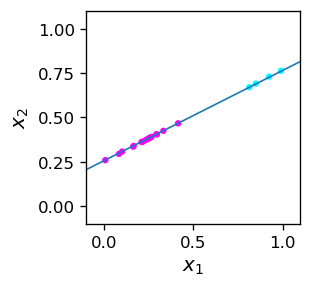

In [20]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(er[:,0],er[:,1],c=er[:,2],s=8,cmap=mpl.cm.cool)

plt.plot(lin[0],lin[1],linewidth=1) # plot the obtained separating line

plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)

plt.show()

```{admonition} Błędna klasyfikacja
:class: note

Przyczyną błędnej klasyfikacji jest fakt, że próbka szkoleniowa nie wyznacza dokładnie linii rozdzielającej, ponieważ między punktami występuje pewna luka. Aby uzyskać lepszy wynik, punkty treningowe musiałyby być „gęstsze” w sąsiedztwie linii rozdzielającej lub też próbka treningowa musiałaby być większa.
```

## Ćwiczenia

```{admonition} $~$
:class: warning

- Pobaw się kodem z wykładu i zobacz, jak procent błędnie zaklasyfikowanych punktów zmniejsza się wraz ze wzrostem wielkości próbki szkoleniowej.
- Gdy algorytm perceptronu jest zbieżny, w pewnym momencie wagi przestają się zmieniać. Popraw kod wykładu, wdrażając zatrzymywanie, gdy wagi nie zmieniają się więcej niż pewna wartość podczas przechodzenia do następnej rundy.
- Uogólnij powyższy klasyfikator na punkty w przestrzeni trójwymiarowej.
```